# Example of sampling

Here we illustrate an example of how to generate samples using our small Python package `smpsite`. Many of the sampling capabilities are directly imported from `pmagpy`. 

In [1]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import matplotlib.pyplot as plt
import smpsite as smp

import numpy as np
np.random.seed(666)

%matplotlib inline

## Define the parameters of the sample

We define a parameter class defined inside `smpsite` that allow us to specify all the parameters of interest at the same time. These parameters include:
- `N`: Total number of sites
- `n0`: Number of samples per site
- `kappa_within_site`: Concentration parameter of the Fisher distribution within each site
- `site_lat`: Latitude of the site
- `site_long`: Longitude of the site
- `outlier_rate`: Fraction of samples that are randomly taken from the uniform distribution in the sphere, with `0.0` representing no outliers and `1.0` representing all outliers. 
- `secular_method`: Method used to sample the VGPs. It includes `G`, `tk03` and `Fisher`. 
- `kappa_secular`: In case of `secular_method="Fisher"`, it specifies the concentration parameter of the Fisher distribution. 

In [2]:
params0 = smp.Params(N=10,
                     n0=5,
                     kappa_within_site=100,
                     site_lat=10, 
                     site_long=0,
                     outlier_rate=0.10,
                     secular_method="G",
                     kappa_secular=None)

## Generate the sample

Once the parameters are specified, we can simulate the sample data:

In [8]:
%%time

df_sample = smp.generate_samples(params0)
df_sample.head()

CPU times: user 14.1 ms, sys: 3.15 ms, total: 17.2 ms
Wall time: 14.5 ms


,sample_site,vgp_long,vgp_lat,vgp_dec,vgp_inc,is_outlier
0,0,280.282044,83.501645,353.484155,21.414245,0
1,0,14.416591,82.931243,1.834416,31.189287,0
2,0,36.734976,80.135259,6.179545,32.762066,0
3,0,88.887877,81.402596,8.730835,19.522055,0
4,0,333.817067,80.131814,355.417757,34.274430,0


## Plot the simulated sample data

We can plot the declination and inclination of all of the simulated samples.

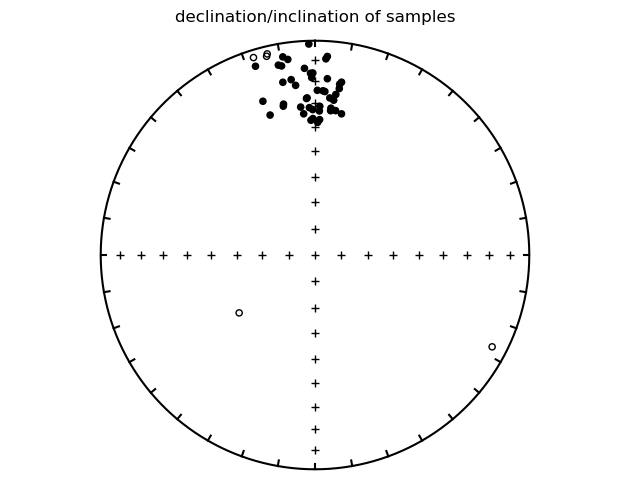

In [14]:
plt.figure()
ipmag.plot_net(1)
ipmag.plot_di(dec=df_sample.vgp_dec.values, inc=df_sample.vgp_inc.values)
plt.title('declination/inclination of samples')
plt.show()

The declination/inclination can be plotted as colored them by site

/Users/unimos/0000_Github/PmagPy/pmagpy/ipmag.py:1935: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


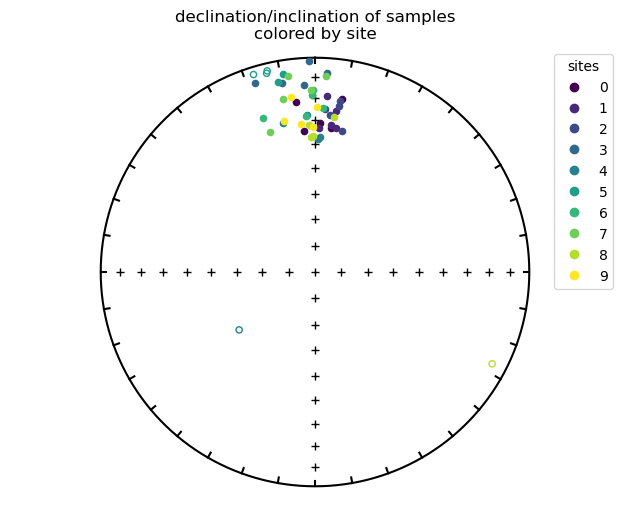

In [15]:
# Create a color map based on unique 'sample_site' values
unique_sites = df_sample['sample_site'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_sites)))
color_map = dict(zip(unique_sites, colors))

ipmag.plot_net(1)

# Use a set to track sites that have already been added to the legend
added_legend_sites = set()

# Iterate through the dataframe and plot each value with its unique color
for index, row in df_sample.iterrows():
    site = row['sample_site']
    color = color_map[site]
    # Using your given column names for declination and inclination
    ipmag.plot_di(row['vgp_dec'], row['vgp_inc'], color=color)
    
    # If the site hasn't been added to the legend, add it
    if site not in added_legend_sites:
        # Use marker='o' for circles, linestyle='' to remove line, and convert site to int for the label
        plt.plot([], [], 'o', label=int(site), color=color, linestyle='')
        added_legend_sites.add(site)

# Show the legend
plt.legend(title='sites',loc='best')
plt.title('declination/inclination of samples\ncolored by site')
plt.show()

## Calculate pole position and calculate angular error

In [11]:
mean_pole = smp.estimate_pole(df_sample, params0, ignore_outliers="True")
print(mean_pole)
angular_error = pmag.angle([mean_pole['pole_dec'], mean_pole['pole_inc']], [0, 90])
print('The angular error is: ', round(angular_error[0],1), 'degrees')

{'pole_dec': 311.28565893265227, 'pole_inc': 86.92289203633084, 'S2_vgp': 58.77578648327861, 'total_samples': 48.0, 'samples_per_site': 5, 'alpha95': 4.950214170523299}
The angular error is:  3.1 degrees


## Plot the pole position

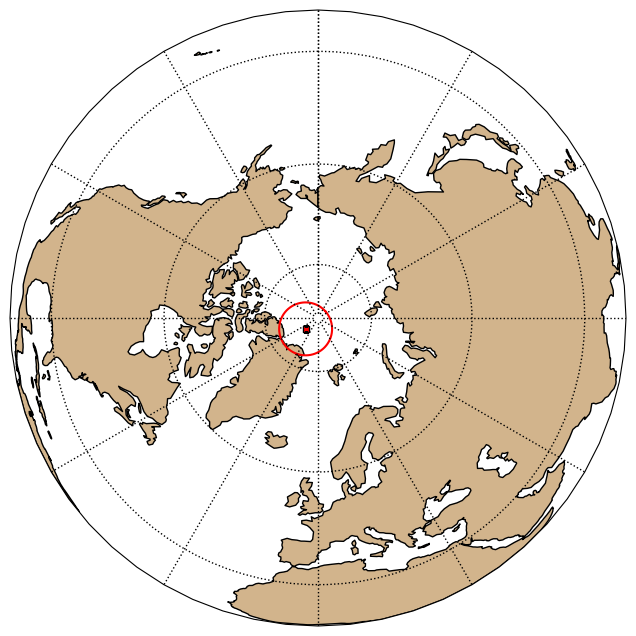

In [12]:
map_axis = ipmag.make_orthographic_map(central_longitude=0,central_latitude=90)
ipmag.plot_pole(map_axis, mean_pole['pole_dec'], mean_pole['pole_inc'], mean_pole['alpha95'], color='r', marker='s', label='Mean Pole')